<a href="https://colab.research.google.com/github/shipra-bhadauria/nlp/blob/main/Machine_Translation(eng_to_deutch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

Import the Required Libraries​

In [ ]:
import numpy as np
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving deu.txt to deu.txt


In [ ]:
def read_text(filename):
  file = open(filename, mode='rt', encoding='utf-8')# open the file
  text = file.read()# read all text
  file.close()
  return text

In [ ]:
def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [ ]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [ ]:
deu_eng = deu_eng[:10000,:]

In [ ]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]
deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['Tom has my book', 'Tom hat mein Buch'],
       ['Tom has nothing', 'Tom hat nichts'],
       ['Tom has options', 'Tom hat mehrere Möglichkeiten']],
      dtype='<U302')

In [ ]:
for i in range(len(deu_eng)):
  deu_eng[i,0] = deu_eng[i,0].lower()
  deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['tom has my book', 'tom hat mein buch'],
       ['tom has nothing', 'tom hat nichts'],
       ['tom has options', 'tom hat mehrere möglichkeiten']],
      dtype='<U302')

<Figure size 1440x576 with 0 Axes>

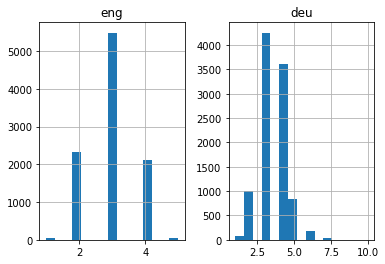

In [ ]:
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
  eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
plt.figure(figsize=(20,8))
length_df.hist(bins=15)
plt.show()

In [ ]:
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
eng_tokenizer=tokenization(deu_eng[:, 0])
eng_vocab_size=len(eng_tokenizer.word_index) + 1

eng_length=8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 2339


In [ ]:
deu_tokenizer=tokenization(deu_eng[:, 1])
deu_vocab_size=len(deu_tokenizer.word_index) + 1

deu_length=8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 3753


In [ ]:
def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)# integer encode sequences
  seq = pad_sequences(seq, maxlen=length, padding='post')# pad sequences with 0 values
  return seq

In [ ]:
# split data into train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [ ]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [ ]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'model.h1.2_Dec'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
12/13 [==========================>...] - ETA: 0s - loss: 3.9965
Epoch 00001: val_loss improved from inf to 2.61432, saving model to model.h1.2_Dec
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.h1.2_Dec/assets
13/13 [==============================] - 14s 1s/step - loss: 3.9468 - val_loss: 2.6143
Epoch 2/30
12/13 [==========================>...] - ETA: 0s - loss: 2.5015
Epoch 00002: val_loss improved from 2.61432 to 2.35902, saving model to model.h1.2_Dec
INFO:tensorflow:Assets written to: model.h1.2_Dec/assets
13/13 [==============================] - 13s 973ms/step - loss: 2.5038 - val_loss: 2.3590
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 2.2647
Epoch 00003: val_loss improved from 2.35902 to 2.22637, saving model to model.h1

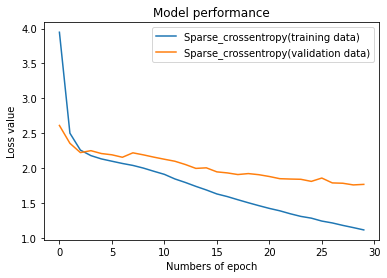

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model performance')
plt.ylabel('Loss value')
plt.xlabel('Numbers of epoch')
plt.legend(['Sparse_crossentropy(training data)','Sparse_crossentropy(validation data)'],loc="upper right")
plt.show()

In [ ]:
model=load_model('model.h1.2_Dec')
preds=model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
    return None

In [ ]:
preds_text = []
for i in preds:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if t == None:
        temp.append('')
      else:
        temp.append(t)
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

ValueError: ignored

In [ ]:
# print 15 rows randomly
pred_df.sample(15)